# Dataset Test

In [31]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
dataset_test_dir = os.listdir("dataset/dataset test")
dataset_test_dir

['AF_04015_ECG1_0', 'NRSDB_N_16273', 'N_04048_ECG1_0']

In [91]:
len(dataset_test_dir)

3

In [92]:
fs = 250
sep=","
idx=0

In [93]:
isNeedUpsampling = False
if fs == 128 : 
    isNeedUpsampling = True

___
# 1. Load Dataset

In [94]:
record = dataset_test_dir[idx]

print(record)

AF_04015_ECG1_0


In [95]:
dataset_dir = "dataset/dataset test/%s/" % record 

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)
        
csv_filenames

['AF_04015_ECG1_0.csv']

- Read & formatting ECG data

In [96]:
def read_csv_to_df(filename, folder, sep=";"):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG1', 'ECG2']

    df['ECG1'] = pd.to_numeric(df['ECG1'])
    df['ECG2'] = pd.to_numeric(df['ECG2'])
    
    # peak reduction
    df[df['ECG1'] > 2] = 2
    df[df['ECG1'] < -2] = -2
    df[df['ECG2'] > 2] = 2
    df[df['ECG2'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

In [97]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir, sep=sep)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - AF_04015_ECG1_0.csv
[INFO] finish data cleansing - AF_04015_ECG1_0.csv
[INFO] finish time cleansing -  AF_04015_ECG1_0.csv


In [98]:
df_ecg.head(10)

,ECG1,ECG2
Time,,
2021-07-18 09:06:50.336,-0.215,0.405
2021-07-18 09:06:50.340,-0.200,0.570
2021-07-18 09:06:50.344,-0.185,0.610
2021-07-18 09:06:50.348,-0.095,0.400
2021-07-18 09:06:50.352,-0.035,0.170
2021-07-18 09:06:50.356,-0.110,0.110
2021-07-18 09:06:50.360,-0.125,0.205
2021-07-18 09:06:50.364,-0.055,0.285
2021-07-18 09:06:50.368,-0.115,0.335


- plot signal 

In [99]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    
    plt.ylim([-2.1, 2.1])
    plt.legend(["ecg 1", "ecg 2"])
    plt.grid(True)
    plt.show()

09:06:50.336000 09:06:56.336000


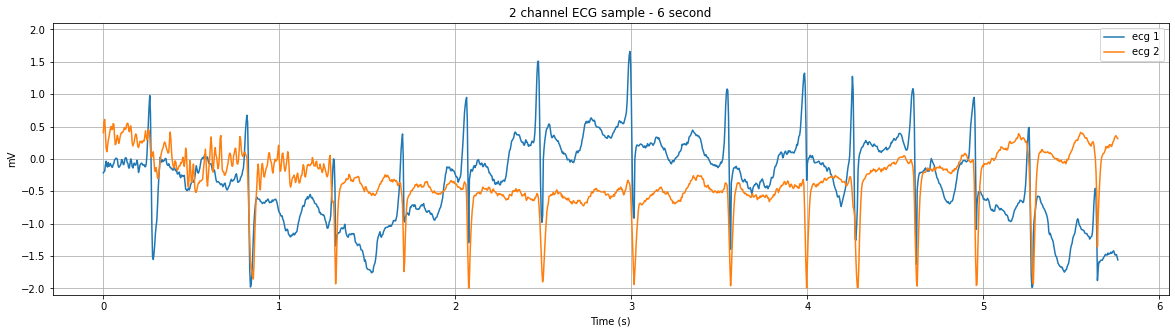

In [100]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=6)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "2 channel ECG sample - 6 second")

___
# 2. Split Dataset per-6s sequece & Apply Baseline Wander Removal

- split each dataframe to 6s sequence and apply Baseline Removal 

In [101]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [102]:
def plot_6s_sample(data, label="2 channel ECG plot - 6s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, ecg1)
    plt.plot(times, ecg2)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["ecg1", "ecg2"])
    plt.grid(True)
    plt.show()

In [103]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [104]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [105]:
time_interval = []
if len(df_ecg) > 0:
    intr = [time_result for time_result in perdelta(df_ecg.index[0], df_ecg.index[-1], timedelta(seconds=6))]
    time_interval.append(intr)

In [106]:
ECG_ALS = []
ECG_ALS_label = []

for tm_int in time_interval :
    for time_intv in list(zip(tm_int, tm_int[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append(0)

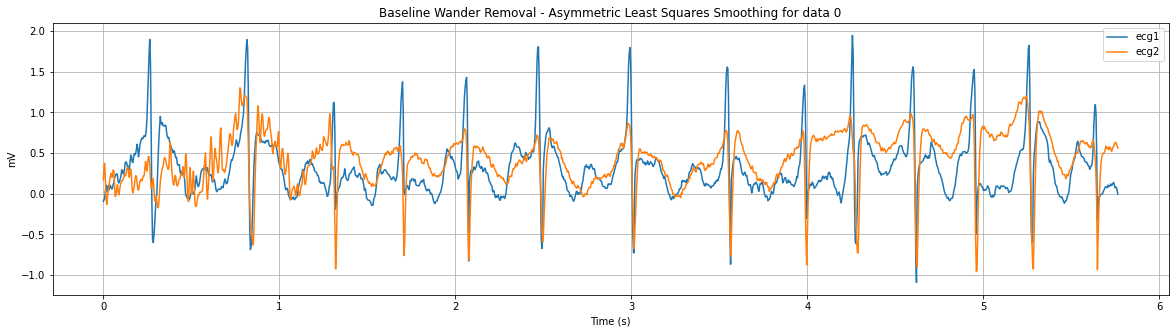

In [107]:
idx = 0
plot_6s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

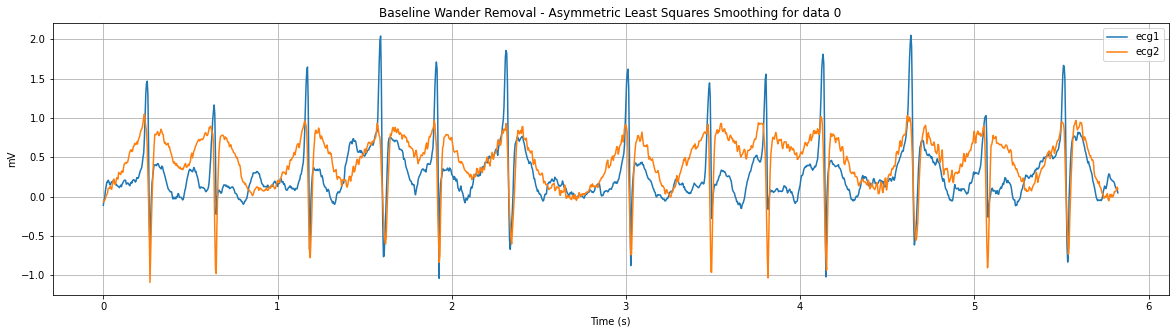

In [108]:
idx = -1
plot_6s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

___
# 3. Signal Normalization
- Signal normalization from -1 to 1

In [109]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [110]:
#scaler = scaler = StandardScaler(with_mean=False, with_std=False) 
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

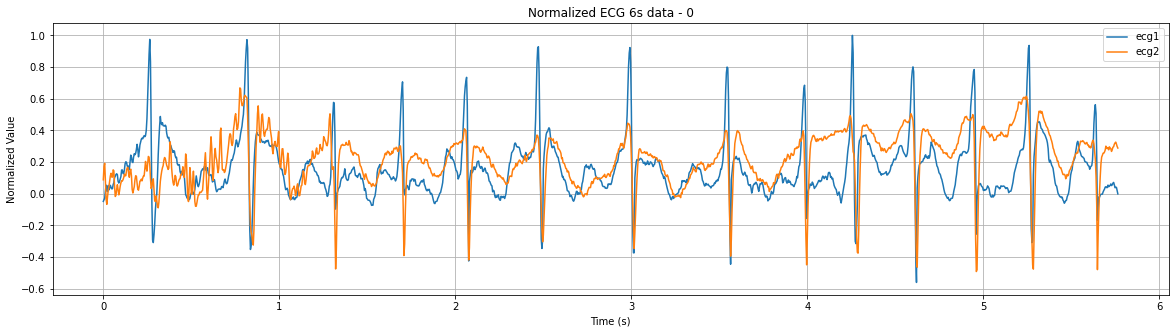

In [111]:
idx = 0
plot_6s_sample(ECG_ALS_Norm[idx], "Normalized ECG 6s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

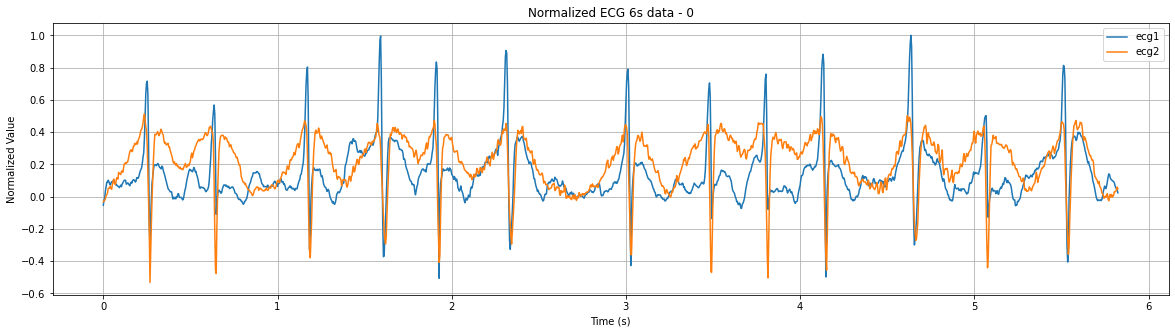

In [112]:
idx = -1
plot_6s_sample(ECG_ALS_Norm[idx], "Normalized ECG 6s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

- Upsampling (128Hz to 250Hz)

In [113]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [114]:

if isNeedUpsampling :
    print("[INFO] upsamplind data")
    new_fs = 250 # Hz 
    ECG_ALS_Norm_Up = []
    for data in ECG_ALS_Norm :
        data1 = np.array(data[0][:,0])
        data2 = np.array(data[1][:,0])
        data1 = upsampling_twice(data1).reshape(-1, 1) 
        data2 = upsampling_twice(data2).reshape(-1, 1) 
        ECG_ALS_Norm_Up.append([data1, data2])
else :
    ECG_ALS_Norm_Up = ECG_ALS_Norm

# 4. Save Signal Sequence per-6s Data 

In [115]:
data = []
pad_size = 1500 # 6s x 250hz
for i in range(len(ECG_ALS_Norm_Up)):
    signal_ch = []
    for ch in [0, 1] :
        signal = np.array(ECG_ALS_Norm_Up[i])[ch, :, 0]
        n = len(signal) if len(signal) <= pad_size else pad_size
        pad = np.zeros(pad_size)
        pad[0:n] = signal[0:n] 
        signal_ch.extend(list(pad))    
    data.append(signal_ch)

In [116]:
ECG = pd.DataFrame(data)

In [117]:
ECG.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.048107,-0.037857,-0.027601,0.021197,0.054607,0.018696,0.013654,0.052335,0.024295,0.034861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.063240,0.053621,0.041354,0.034382,0.030057,0.033673,0.034637,0.038244,0.039197,0.029549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.046591,0.046362,0.055966,0.031156,0.048131,0.052814,0.055035,0.049878,0.064378,0.064121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.076716,0.094274,0.115747,0.180278,0.250679,0.150791,0.035236,0.064507,0.085931,0.095590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.048502,-0.011398,-0.006173,0.008873,0.046008,0.083166,0.105638,0.110977,0.108997,0.102156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
# save Signal Sequence 6s 

ECG.to_csv("dataset/dataset_test_%s_sequence_6s_2_ch.csv" % record, index=False, header=False)